<hr>
<h1> Regressão Logística Aplicada ao SASD Memory Effect </h1>
<hr>

<h2><strong>Resumo</strong></h2>
Utilizando variáveis que são pertinentes ao SASD memory effect e ao clima regional do estado de São Paulo, montamos um modelo de regressão logística para predizer o sinal das anomalias de temperatura entre Junho e Agosto, com aproximadamente um ano de antecedência. Esse modelo estatístico apresentou, dentro do conjunto de treinamento, valores de acurácia, precisão e recall de aproximadamente 70%. Ao analizarmos apenas situações de neutralidade de El Nino - Oscilação Sul, observamos uma performace geral de aproximadamente 80%. Notamos que, embora ENSO e SASD sejam conhecidos por seus efeitos no continente sulamericano, o modelo apontou para o SASD, ocorrido no ano anterior, como seu principal componente preditivo. Isso indica a importância do SASD memory effect para o clima regional do sudeste brasileiro e evidencia o potencial de seu uso como indicador preditivo.


<h2><strong>Introdução</strong></h2>


<strong>Sobre o SASD Memory Effect:</strong>

Existe um padrão de variabilidade acoplada chamado Dipolo Subtropical do Atlântic Sul (SASD, do inglês) que conecta a variabilidade atmosférica (variabilidade da Alta Subtropical) com a variabilidade das anomalias de temperatura da superfície do mar (TSM) no Atlântico Sul.

Santis et al. 2020 descreveu que, quando um evento de SASD ocorre durante o inverno-primavera, existe um processo oceânico que armazena as anomalias de TSM em camadas mais produndas do oceano, e que no ano seguinte retornam à superfície. Esse processo constitui um efeito de memória ao SASD.

Muito bem. O efeito de memória traz imediatamente a idéia de previsibilidade. Seria possível então, dado um evento de SASD na época certa, predizer que no ano seguinte observaremos condições específicas, determinadas por esse efeito de memória. Posteriormente, foi verificado que as anomalias de TSM que retornam no ano seguinte impactam na atmosfera. Especificamente, anomalias de temperatura do ar em superfície são observadas no estado de São Paulo entre junho, julho e agosto, e estão associadas ao efeito de memória. Vamos aqui aplicar um modelo de regressão logística ao SASD memory effect, com o intuito de  estimar a probabilidade de, dado um evento de SASD num determinado inverno-primavera, observarmos anomalias quentes ou frias sobre o estado de São Paulo no inverno do ano subsequente.

<strong> Sobre a Regressão Logística:</strong>

A regressão logistica nos oferece um modelo regressor para variáveis categóricas, como por exemplo Y = (SIM , NÃO), Y = (Sucesso , Fracasso). 

A regressão nos dá, pois, a chance de um conjunto de observações ($X$) resultarem em uma determinada classe admitida por Y. O ajuste se dá com o uso da função sigmoide, dada por:

Função de ajuste: $\sigma(z) = \frac{1}{1+e^{-z}}$

donde:
<li>$z=\beta^T X $
<li>$\beta= \beta_0, \beta_1 , \beta_2, ..., \beta_n $ são coeficientes da função de ajuste</li>
<li>$X= X_1 , X_2 , ..., X_n $ são as variáveis independentes</li>
<li>$\beta^T X= \beta_0+ \beta_1 X_1 , \beta_2 X_2 , ..., \beta_n X_n $ é a combinação linear de todas as variáveis independentes</li>

O que se faz na regressão logistica é encontrar os coeficientes $\beta$ que maximizam a verossimilhança, ou, equivalentemente, minimizam a função custo (erro).



<h1> Objetivo do Estudo: </h1>

Aplicar o modelo de Regressão Logística</strong> ao SASD memory effect, para verificarmos se conseguimos predizer o sinal das anomalias de temperatura sobre São Paulo, entre Junho e Julho, com cerca de um ano de antecedência.

Assim, temos:

- Y = sinal da anomalia de temperatura do ar sobre o estado de São Paulo (aproximadamente), tomada entre Junho e Agosto;

    Defino Y=0 para anomalias negativas, e Y=1 para anomalias positivas;

<h2> É preciso estabelecer quais variáveis ($X$) são relevantes ao problema.</h2>
<li><h3> Vamos elencar inicialmente três variáveis independentes: </li>
   

<li>$X_1$: SASDIy0[julho ano 0], precursora do efeito de memória;</li>
<li>$X_2$: SASDIy1[julho ano 1]; pode influenciar o clima na região de interesse</li>
<li>$X_3$: ENSO[julho ano 1]; pode influenciar o clima na região de interesse</li>

- SASDI é uma medida do SASD (SASD Index), e é o prinpical índice envolvido no efeito de memória. O SASDI é medido como a diferença das anomalias entre cada pólo do dipolo (polo sudoeste menos polo nordeste);
- ENSO é o índice do El Nino - Oscilação Sul, e é incluído por seus conhecidos impactos no clima regional sulamericano;
- SASD no ano 1 também é incluído, pois também pode influenciar o valor de Y;

<strong>IMPORTANTE</strong> notar que: SASDIy0 é tomado em julho de um determinado ano (ano 0), enquanto que Y, SASDIy1 e ENSO são tomados entre junho e agosto do ano seguinte (ano 1). Há, portanto, aproximadamente um ano de diferença entre SASDIy0 e Y.

<hr>
<h2>Código:</h2>

Importando as bibliotecas necessárias ...

In [172]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score, roc_curve, classification_report,accuracy_score, recall_score, precision_score, confusion_matrix, auc

<hr>
Função para abrir os arquivos netcdf.



In [189]:
def openfiles():
    # Dados começam todos em 15 jan 1980.
    Sdata= xr.open_dataset('data/MEAN_SASDb.nc')
    Edata= xr.open_dataset('data/Nino3b_ERv5.nc')
    Tdata= xr.open_dataset('data/TSP_anom.nc')
    sasdi=np.array(Sdata['MEDIAB'][:])
    nino3=np.array(Edata['NINO3B'][:])
    #p1=np.array(Pdata['PREC01'][:])
    #p2=np.array(Pdata['PREC02'][:])
    tanom=np.array(Tdata['TANOM'][:])
    return sasdi,nino3,tanom

In [190]:
sasda,ninoa,tanoma=openfiles()

<hr>
Agora extraio SASDIy0 em Julho (ano 0), SASDy1 e NINO em Julho (ano 1) e Tanom entre Junho e Agosto (ano 1).

Em seguinda, transformo tanom (Real) em binário (0,1), e armazeno as variáveis num dataframe (df).

In [191]:
sasdi=np.array([ np.mean(sasda[i,0]) for i in range(6,29*12,12) ])
#sasdi_n=(sasdi-sasdi.mean())/sasdi.std()
sasdiy1=np.array([ np.mean(sasda[i,0]) for i in range(18,30*12,12) ])
#sasdiy1_n=(sasdiy1-sasdiy1.mean())/sasdiy1.std()
nino=np.array([  np.mean(ninoa[i])  for i in range(18,30*12,12)   ])
#nino_n=(nino-nino.mean())/nino.std()
tanom=np.array([ np.mean(tanoma[i:i+3])  for i in range(17,30*12,12)  ])
Y= np.where(tanom > 0, 1, np.where(tanom < 0, 0,0))


df = pd.DataFrame({'SASDIy0':sasdi*10,'SASDIy1':sasdiy1*10,'ENSO':nino*10,'Tanom':Y})


df.head()

,SASDIy0,SASDIy1,ENSO,Tanom
0,4.096648,7.044730,1.054966,0
1,7.044730,4.862110,14.934173,1
2,4.862110,0.534298,14.435715,0
3,0.534298,-4.961438,-0.247161,1
4,-4.961438,-3.092822,-3.499777,0


<hr>
Defino algumas funções para iniciar as variáveis X e Y, incluir Xo=1 no vetor X, e calcular a função sigmoide:

In [192]:
def initiate():
    n_features = len(df.columns)-1 
    X = np.array(df.drop('Tanom',1)) 
    y = df.iloc[:,n_features:n_features+1].values
    scaler = StandardScaler()
#    scaler.fit(X)
#    X = scaler.transform(X)
    return n_features, X, y

Importante adicionar o $X_0=1$ em X, para que possamos multiplicar os vetores $X$ e $\beta$. Faço isso com a função abaixo:

In [193]:
def insert_ones(X):
    ones = np.ones([X.shape[0],1])
    return np.concatenate((ones,X),axis=1)

Vamos definiar a função sigmoid, que usaremos para vizualizar o ajuste.

In [195]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

<hr>


<h1> Muito bem... </h1>

Vamos calcular a Regressão Logistica utilizando bibliotecas específicas, para obtermos algumas informações estatísticas relevantes acerca dos resultados:

In [196]:
modelo = smf.glm(formula='Tanom ~ SASDIy0 + SASDIy1+ ENSO', data=df,
                family = sm.families.Binomial()).fit()
print(modelo.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Tanom   No. Observations:                   29
Model:                            GLM   Df Residuals:                       25
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16.787
Date:                Thu, 24 Feb 2022   Deviance:                       33.574
Time:                        20:52:05   Pearson chi2:                     29.2
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1089      0.518     -0.210      0.8

<strong>Notemos:</strong>

- Apenas SASDIy0 apresentou p < 0.05, indicando que há evidências de que seu coeficiente é estatisticamente diferente de zero, com um grau de significância de 5%;

- Como as variáveis em X não foram normalizadas, não podemos comparar seus coeficiêntes. Contudo, se o fossem, os resultados seriam:

- $\beta_1=1.03$
- $\beta_2=-0.23$
- $\beta_3=0.43$

Os coeficientes para os valores normalizados nos informam que SASDIy0 é o termo que mais contribui com o ajuste.

Não vou normalizar os dados para que, na hora de vizualizá-los, vejamos um ajuste mais coerente à sigmoide.
<hr>

Vou refazer o ajuste mais uma vez, mas agora utilizando o <strong> sklearn</strong>.


<strong>Outro ponto...</strong> Vou utilizar apenas a variável independente SASDy0, pois foi a única com coeficiente estatisticamente significante.

In [201]:

baseline_df = df[['Tanom', 'SASDIy0', 'SASDIy1' ,'ENSO']].dropna()
y = np.array(baseline_df.Tanom)
X = np.array(pd.get_dummies(baseline_df[['SASDIy0']], drop_first=True))
#print(X)

In [202]:
model = LogisticRegression()
model.fit(X, y)
y_pred = model.predict(X)
print(classification_report(y, model.predict(X)))

              precision    recall  f1-score   support

           0       0.69      0.64      0.67        14
           1       0.69      0.73      0.71        15

    accuracy                           0.69        29
   macro avg       0.69      0.69      0.69        29
weighted avg       0.69      0.69      0.69        29



<hr>
Esses são os resultados ao se utilizar todos os dados. Observamos um desempenho geral de aproximadamente 70%.


<strong>Vamos</strong> agora utilizar a metodologia de treino e teste de modelos de "Machine Learning". Quero dizer: Vamos separar os dados em duas amostras: uma para obtermos a função de ajuste (treinar o modelo) e outra para testar o modelo. Fazemos isso para que o treino não seja feito com os dados utilizados na otimização dos coeficientes da função regressora.



Pois bem. Temos, entretanto, que ao treinar o modelo com o conjunto de testes, obtemos resultados que são dependentes da amostra que utilizamos para o treino. O mesmo vale para o momento de testar o modelo. Isso quer dizer que podemos ter resultados diferentes, dependendo de quais dados utilizamos para treinar e testar o modelo.

Para contornar esse problema, o que faço aqui é gerar 500 ajustes diferentes, mudando as amostras de treino e teste. Os resultados abaixo mostram a distribuição da performace do modelo ao mudarmos aleatoriamente as amostras.



/home/wlademir/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wlademir/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wlademir/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wlademir/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: Un

0.6666666666666666 0.6666666666666666 0.6666666666666666 0.6666666666666666


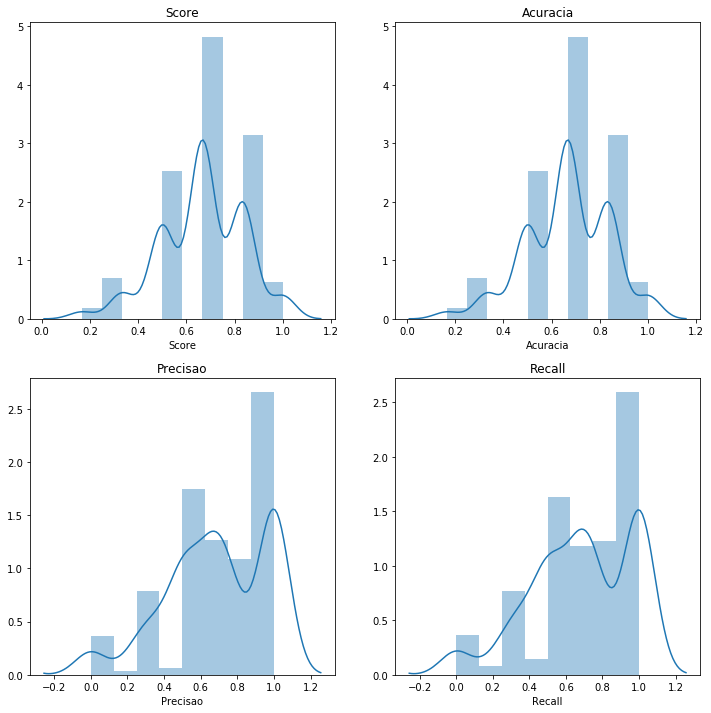

In [203]:
nereast=1
nresample=500
score=np.zeros(nresample)
acuracia=np.zeros(nresample)
precisao=np.zeros(nresample)
recall=np.zeros(nresample)
for rand in range(0,nresample):
    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    model = LogisticRegression(random_state=rand,solver='liblinear')
    #random_stateint, RandomState instance, default=None

    #Used when solver == ‘sag’, ‘saga’ or ‘liblinear’
    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    score[rand]=model.score(x_test, y_test)
    recall[rand]=recall_score(y_test, y_pred)
    acuracia[rand]=accuracy_score(y_test, y_pred)
    precisao[rand]=precision_score(y_test, y_pred)


metricas = pd.DataFrame({'Score':score,'Acuracia':acuracia,'Precisao':precisao,'Recall':recall})
features=('Score','Acuracia','Precisao','Recall')
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
for col, ax in zip(features, axs.ravel()):
    x=metricas.loc[:,col]
    sns.distplot(x, ax=ax)
    ax.set_title(col)
    #    sns.distplot(x=metricas,x=col,bins=bins,ax=axs)
print(np.median(score),np.median(acuracia),np.median(precisao),np.median(recall))

<hr>
Os resultados de performace de Acurácia, Precisão e Recall ficam distribuidos em torno de 67%. Relembrando que:

<hr>
<strong>Acurácia</strong> : Indica a performace geral do modelo de classificação. Dentre todos os eventos, quantos o modelo classificou corretamente 

$$acurácia =\frac{TP+TN}{FP+TP+FN+TN}$$

<strong>Precisão </strong>: Dentre todos os eventos positivos, quantos o modelo acertou sua classificação.

$$precisao =\frac{TP}{FP+TP}$$


<strong>Recall</strong>: A proporção das classificações Positivas que foram corretamente identificadas
$$recall =\frac{TP}{FN+TP}$$



<h1>Até aqui, podemos dizer que ...</h1>

Dentro do conjunto de treinamento, o modelo apresentou valores de acurácia, precisão e recall de aproximadamente 70%, e, durante o teste do modelo, uma distribuição de resultados de performace em torno de 66%. Embora não sejam números expressivamente bons, vale notar que a previsibilidade sazonal tem ainda limitações temporais e espaciais bastante significativas, de forma que 70% de precião e recall para uma previsão de 12 meses é, sim, um resultado bastante interessante. É importante também notar que, embora ENSO e SASD sejam conhecidos por seus efeitos no clima regional, o modelo regressor apontou para o SASDI_y0 como seu principal componente. Esses resultados evidenciam a importancia do SASD memory effect para o clima regional do sudeste brasileiro e seu real potencial na aplicação como índice preditivo.


<hr>
<h1> Mais um teste ... </h1>
Antes de encerrar, vamos analisar apenas as situações com condições Neutras de ENSO em Julho do ano 1. Embora ENSO e SASDy1 tenham apresentado coeficientes menores que SASDy0, seus efeitos não são necessariamente desprezíveis. Faço então um filtro, considerando como limiar o valor do desvio padrão para ENSO, e excluo qualquer evento para o qual ENSO seja maior que o limiar estabelecido.

    SASDIy0   SASDIy1       ENSO  Tanom  Estatus  Status
0  4.096648  7.044730   1.054966      0        0       1
1  7.044730  4.862110  14.934173      1        1       0
2  4.862110  0.534298  14.435715      0        1       0
3  0.534298 -4.961438  -0.247161      1        0       0
4 -4.961438 -3.092822  -3.499777      0        0       0


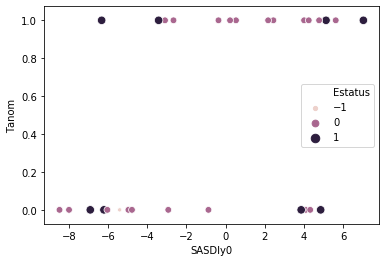

    SASDIy0   SASDIy1      ENSO  Tanom  Estatus  Status
0  4.096648  7.044730  1.054966      0        0       1
3  0.534298 -4.961438 -0.247161      1        0       0
4 -4.961438 -3.092822 -3.499777      0        0       0
5 -3.092822 -6.213120  5.859502      1        0      -1
8 -4.781501 -0.872271  1.897860      0        0       0


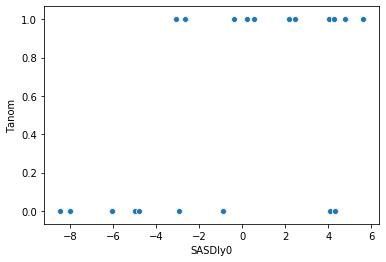

In [204]:
Sstatus= np.where(sasdiy1 > np.std(sasdiy1)*1.1, 1, np.where(sasdiy1 < -np.std(sasdiy1)*1.1, -1,0))
Estatus= np.where(nino > np.std(nino)*1, 1, np.where(nino < -np.std(nino)*1, -1,0))


df = pd.DataFrame({'SASDIy0':sasdi*10,'SASDIy1':sasdiy1*10,'ENSO':nino*10,'Tanom':Y,'Estatus':Estatus,'Status':Sstatus})
print(df.head())

fig, ax = plt.subplots(figsize=(6,4))  
sns.scatterplot(x='SASDIy0', y='Tanom',data=df,hue='Estatus',size='Estatus')
plt.show()
df = df[df.Estatus == 0]
#df = df[df.Status == 0]
print(df.head())
fig, ax = plt.subplots(figsize=(6,4))  
sns.scatterplot(x='SASDIy0', y='Tanom',data=df)

<strong> Percebe-se </strong> que, ao selecionarmos apenas casos de ENSO e SASD neutros, a separação de Tanom com relação ao valor de SASDy0 é mais evidente. Espera-se assim um melhor ajuste da função logistica aos dados. Vamos ver como o sklearn faz o ajuste para nós ...

In [205]:
df.drop('Estatus',axis='columns', inplace=True)
df.drop('Status',axis='columns', inplace=True)

df.head()
#print(df)


,SASDIy0,SASDIy1,ENSO,Tanom
0,4.096648,7.044730,1.054966,0
3,0.534298,-4.961438,-0.247161,1
4,-4.961438,-3.092822,-3.499777,0
5,-3.092822,-6.213120,5.859502,1
8,-4.781501,-0.872271,1.897860,0


In [206]:
n_features, X, y = initiate()
model = LogisticRegression()
model.fit(X, y)
y_pred = model.predict(X)
print(classification_report(y, y_pred))
print(model.coef_)

              precision    recall  f1-score   support

           0       0.78      0.78      0.78         9
           1       0.82      0.82      0.82        11

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20

[[ 0.38662064 -0.2218457   0.11661553]]


/home/wlademir/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until
/home/wlademir/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [207]:
X = insert_ones(X) 

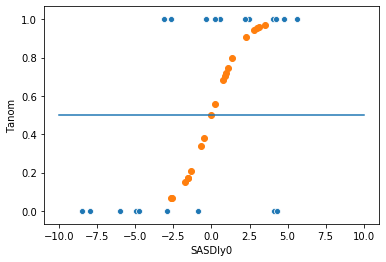

In [208]:
w = np.append(model.intercept_.ravel(), model.coef_)
sig_ajusted=sigmoid(X @ w.T)
xl=np.array(X @ w.T)
fig, ax = plt.subplots(figsize=(6,4))  
ax=sns.scatterplot(x='SASDIy0', y='Tanom',data=df,ax=ax)
ax.scatter(xl, sig_ajusted)
ax.plot([-10,10],[0.5,0.5])
#ax.set_xlim([-2,2])

#ax.scatter(df['SASDIy0'], df['Tanom'])
#ax=sns.scatterplot(x=X[:,1], y='Tanom',data=df,ax=ax)

<hr>
<h1><strong>Considerações Finais </strong></h1>
Observamos uma melhoria na performace do ajuste para cerca de 80%, ao tratarmos apenas situações neutras de ENSO julho do ano 1. Contudo há uma redução na quantidade de dados, que já era demasiadamente pequena. Realizar esse tipo de análise esbarra imediatamente no limite temporal dos dados observacionais, tornando-os escassos, o que inviabiliza realizar as etapas de treino e teste com subamostras distintas e suficientes. A utilização de dados de reanálises, por exemplo, poderia ser uma alternativa, mas o viés presente nesses tipos de dados, sobretudo anteriormente ao início das observações por satélite, compromete sua utilização. As bases de dados observacionais recaem em problema semelhante, uma vez que há pouca amostragens ante de 1980, sobretudo no hemisfério sul. Os resultados apresentados aqui, apesar de esbarrar no problema de escasses de dados, apresentam-se promissores com relação à utilização do SASD memory effect como índice preditor. Será necessário, entretanto, aguardar pelo aumento natural das observações com o tempo, ou o surgimento de reanálises que reconstruam a variabilidade do clima passado de modo satisfatório.